In [1]:
import pandas as pd
import ast, json
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("/home/nhan/Documents/renting/data/fake_user_data.csv")

In [3]:
df.head()

,Quê quán,Tuổi tác,Giới tính,Nghề nghiệp,Thu nhập (triệu),Ngân sách thuê nhà (triệu),Thói quen sinh hoạt,Yêu cầu tiện nghi,Địa điểm mục tiêu,Khu vực mong muốn,Diện tích (m2),Số phòng
0,Hưng Yên,23,Nữ,Kỹ sư,10,3,Thích yên tĩnh,"['An ninh tốt', 'Máy lạnh', 'Nhà vệ sinh riêng']","{'Latitude': 23.263898, 'Longitude': 105.654865}",Hoài Đức,27,1
1,Điện Biên,24,Nữ,Freelancer,19,5,Nuôi thú cưng,"['Nhà vệ sinh riêng', 'Bếp', 'Nội thất sẵn', '...","{'Latitude': 21.60114, 'Longitude': 102.425265}",Phú Xuyên,43,2
2,Bắc Kạn,21,Nữ,Sinh viên,4,2,Nuôi thú cưng,"['Nhà vệ sinh riêng', 'Chỗ để xe', 'Nội thất s...","{'Latitude': 16.419646, 'Longitude': 106.183285}",Thạch Thất,20,3
3,Cao Bằng,32,Nữ,Công nhân,16,5,Không quan trọng,['Nhà vệ sinh riêng'],"{'Latitude': 22.313006, 'Longitude': 107.009253}",Cầu Giấy,48,3
4,Nam Định,28,Nam,Phục vụ,9,3,Thích yên tĩnh,"['Bếp', 'Nhà vệ sinh riêng', 'Nội thất sẵn', '...","{'Latitude': 8.948569, 'Longitude': 108.036487}",Quốc Oai,16,4


In [4]:
trans = {
    "nominal" : {
        "Thói quen sinh hoạt" : {
            "special" : "Thói quen sinh hoạt",
            "props" : ["Thích yên tĩnh", "Nuôi thú cưng"]
        },
        "Yêu cầu tiện nghi" : {
            "special" : None,
            "props" : ['Bếp', 'Nội thất sẵn', 'Chỗ để xe', 'An ninh tốt', 'Máy lạnh', 'Nhà vệ sinh riêng']
        }
    },
    "ordinal" : None,
    "binary" : {
        "Giới tính" : {
            "props" : ["nam"]
        }
    },
    "numerical" : {
        "standardization" : {
            "features" : ['Tuổi tác','Ngân sách thuê nhà (triệu)','Diện tích (m2)','Số phòng']
        }
    },
    "col2drop" : ['Quê quán','Thu nhập (triệu)','Khu vực mong muốn','Nghề nghiệp'],
    "col_order" : ["Tuổi tác", "Giới tính", "Ngân sách thuê nhà (triệu)", "Diện tích (m2)", "Số phòng", "Thích yên tĩnh", "Nuôi thú cưng", "Bếp", "Nội thất sẵn", "Chỗ để xe", "An ninh tốt", "Máy lạnh", "Nhà vệ sinh riêng", "Vĩ độ", "Kinh độ"]
}

In [5]:
def transform(df, trans):
    def standardize(col):
        m, std = df[col].mean(), df[col].std()
        df[col] = df[col].apply(lambda x: (x - m) / std)
        return m, std
    normalize_coeff = {

    }

    # Drop unused columns
    df.drop(trans['col2drop'],axis=1,inplace=True)

    #nomial features
    for feature in trans['nominal']:
        for prop in trans['nominal'][feature]['props']:
            if feature != 'Yêu cầu tiện nghi':
                df[prop] = df[feature].apply(lambda x: 1 if x in [prop, trans['nominal'][feature]['special']] else 0)
            else:
                df[prop] = df[feature].apply(lambda x: 1 if prop in ast.literal_eval(x) else 0)
        df.drop(feature, axis=1, inplace=True)
    
    #binary features
    for feature in trans['binary']:
        df[feature] = df[feature].apply(lambda x: 1 if str.lower(x).strip() in trans['binary'][feature]["props"] else 0)
    
    #numerical features
    for type in trans['numerical']:
        if type == "standardization":
            for feature in trans['numerical']['standardization']['features']:
                m, std = standardize(feature)
                normalize_coeff[feature] = {
                    "type" : "standardization",
                    "mean" : m,
                    "std" : std
                }
    
    #special features
    df['Vĩ độ'] = df['Địa điểm mục tiêu'].apply(lambda x: ast.literal_eval(x)['Latitude'])
    df['Kinh độ'] = df['Địa điểm mục tiêu'].apply(lambda x: ast.literal_eval(x)['Longitude'])
    df.drop('Địa điểm mục tiêu',axis=1,inplace=True)
    for feature in ['Vĩ độ','Kinh độ']:
        m, std = standardize(feature)
        normalize_coeff[feature] = {
            "type" : "standardization",
            "mean" : m,
            "std" : std
        }
    return df[trans['col_order']], normalize_coeff

df, coeff = transform(df,trans)

In [6]:
df

,Tuổi tác,Giới tính,Ngân sách thuê nhà (triệu),Diện tích (m2),Số phòng,Thích yên tĩnh,Nuôi thú cưng,Bếp,Nội thất sẵn,Chỗ để xe,An ninh tốt,Máy lạnh,Nhà vệ sinh riêng,Vĩ độ,Kinh độ
0,-1.003576,0,0.030737,-0.234872,-1.310940,1,0,0,0,0,1,1,1,1.710183,-0.114955
1,-0.792342,0,1.460363,1.111101,-0.424571,0,1,1,1,1,0,0,1,1.334149,-1.673646
2,-1.426046,0,-0.684076,-0.823736,0.461798,0,1,0,1,1,0,0,1,0.162351,0.140074
3,0.897537,0,1.460363,1.531718,0.461798,0,0,0,0,0,0,0,1,1.495138,0.538708
4,0.052597,1,0.030737,-1.160229,1.348167,1,0,1,1,0,1,0,1,-1.527239,1.034479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.475067,1,-1.398890,0.690484,0.461798,1,0,0,1,0,1,0,1,0.371600,-0.693046
996,1.320006,0,-0.684076,0.438114,-0.424571,0,0,0,1,1,1,0,0,1.245853,-1.338450
997,-0.158637,1,0.745550,-0.655489,0.461798,1,0,1,1,0,1,1,0,-1.564410,-0.610533
998,0.475067,0,-1.398890,0.017498,1.348167,1,0,1,1,1,0,0,1,-0.351713,-0.052116


In [7]:
X_train, X_test = train_test_split(df,test_size=0.1,random_state=42)

In [142]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
res = []
for _ in range(1000):
    n_clusters = list(range(3,30))
    best_n = 0
    best_score = -1
    for n in n_clusters:
        kmeans = KMeans(n_clusters=n,n_init='auto')
        kmeans.fit(X_train)  
        score = silhouette_score(X_train, kmeans.labels_)
        if score > best_score:
            best_score = score
            best_n = n
    res.append(best_n)

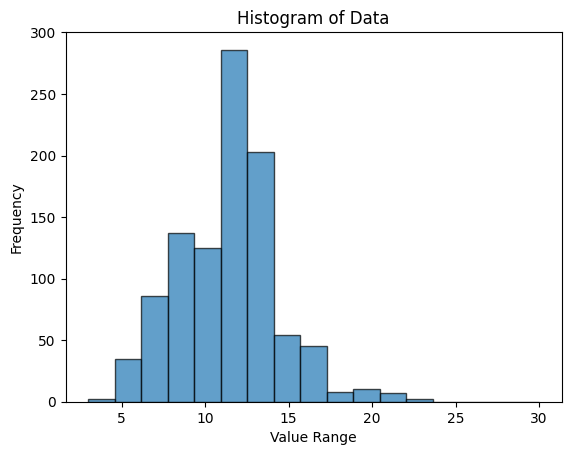

In [144]:
import matplotlib.pyplot as plt


plt.hist(res, bins=17, range=(3, 30), edgecolor='black', alpha=0.7)

plt.title('Histogram of Data')
plt.xlabel('Value Range')
plt.ylabel('Frequency')

plt.show()

In [8]:
best_n = 11
kmeans = KMeans(n_clusters=best_n, n_init='auto')
kmeans.fit(df) 
train_labels = kmeans.labels_
cluster = {}
for i in range(0,best_n):
    X = df.iloc[np.where(train_labels == i)[0]]
    knn = NearestNeighbors(n_neighbors=20)
    knn.fit(X)
    cluster[i] = {"model" : knn, "X" : X}

In [9]:
import pickle

with open("seg_model/kmean_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

with open("seg_model/knn_models.pkl", "wb") as f:
    pickle.dump(cluster, f)

with open("seg_model/transform.pkl", "wb") as f:
    pickle.dump(trans, f)

with open("seg_model/nor_coeff.pkl", "wb") as f:
    pickle.dump(coeff, f)